<h1>MANDATORY PACKAGES</h1>

In [1]:
%matplotlib  inline
import os
import datetime
import numpy as np
from collections import namedtuple
from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd
import collections
import netCDF4 #conda install netCDF4
import cartopy #conda install cartopy
import cf_units #conda install -c conda-forge cf_units
from isodate import parse_duration #conda install isodate
import cartopy.feature as cfeature
plt.rcParams.update({'font.size': 16})

<ul><b>Warning!</b>: Some of the packages will need a prior installation. A clear indication of this will be the see a <i style="color:red">ModuleNotFoundError: No module named '{module name}}'</i> when running the next cell.<br>
For each package throwing this error, please open first the Anaconda Powershell Prompt and run the installing command specified after the '#' next to the package.</ul>

<h1>In Situ HF-radars</h1>

In Situ 'HF-radars' are fixed-stations that provides grided-like data of surface currents in the area nearby its antennas. It's platform data source is 'HF'.

Search for the latest files produced by HF-radar platforms in the IBI region and download at least one. See how <a href="cmemsInSitu_dataDonwload.ipynb" target="_blank">here</a>. <br>You can use the next configuration:

In [2]:
configuration = {
    'user': '', #type CMEMS user name <= Don't you have one? ask here: http://marine.copernicus.eu/services-portfolio/register-now/
    'password': '', #type CMEMS password <= Don't you have one? ask here: http://marine.copernicus.eu/services-portfolio/register-now/
    'product': 'INSITU_IBI_NRT_OBSERVATIONS_013_033', #options: INSITU_IBI_TS_REP_OBSERVATIONS_013_040 or INSITU_IBI_NRT_OBSERVATIONS_013_033
    'archives': ['latest'], #options: history (NRT & REP), monthly (NRT), latest (NRT))
    'searching_criteria':{
        'bbox': None, #Define here the area you want to check for data (expected order: south-east longitude, south-east latitude, north-west longitude, north-west latitude)
        'timerange':None,#Define here the time-range you want to check for data (expected format: "YYYY-mm-ddTHH:MM:SSZ")
        'parameters':None, #Define here the parameters you are interested in (see more at: https://archimer.ifremer.fr/doc/00422/53381/
        'sources': ['HF']#Define here the sources you are interested in (see more at: http://resources.marine.copernicus.eu/documents/PUM/CMEMS-INS-PUM-013-048.pdf),
    }
}

Remember to set a threshold on calling the 'search' function, otherwise a large number of files will start downloading.

<h1>netCDF metadata</h1>

Let's read one of the HF-radar files downloaded:

In [6]:
filename = 'GL_LATEST_TV_HF_HFR-Ibiza-Total_20190412.nc' #set the full path to the file if it isn't in the working directory

In [28]:
ds = netCDF4.Dataset(filename)

Let's have a look to the file global attributes:

In [11]:
for attr in ds.ncattrs():
    print(attr+ '='+ getattr(ds, attr))

site_code=HFR-Ibiza
platform_code=HFR-Ibiza-Total
data_mode=R
DoA_estimation_method=Direction Finding
calibration_type=APM
last_calibration_date=2017-01-26T00:00:00Z
calibration_link=ereyes@socib.es
title=Near Real Time Surface Ocean Radial Velocity by HFR_Ibiza
summary=The data set consists of real-time continuous coastal ocean surface current maps in the Ibiza Channel (Western Mediterranean) averaged over a time interval of 1 hour around the cardinal hour, measured by the coastal High-Frequency Radars installed. Surface ocean velocities estimated by HF Radar are representative of the upper 0.9 meters of the ocean for a central frequency of 13.5 MHz. 
source=coastal structure
source_platform_category_code=17
institution=SOCIB - Balearic Islands Coastal Observing and forecasting System
institution_edmo_code=3410
data_assembly_center=European HFR Node
data_type=HF radar total data
feature_type=surface
format_version=v2.1
Conventions=CF-1.6, OceanSITES-Manual-1.2, Copernicus-InSituTAC-SR

Let's see which variables contains the file:

In [12]:
for name, variable in ds.variables.items(): 
    print(name)

TIME
LATITUDE
LONGITUDE
crs
SDN_CRUISE
SDN_STATION
SDN_LOCAL_CDI_ID
SDN_EDMO_CODE
SDN_REFERENCES
SDN_XLINK
DEPH
EWCT
NSCT
EWCS
NSCS
CCOV
GDOP
TIME_SEADATANET_QC
POSITION_SEADATANET_QC
DEPTH_SEADATANET_QC
QCflag
VART_QC
GDOP_QC
DDNS_QC
CSPD_QC
NARX
NATX
SLTR
SLNR
SLTT
SLNT
SCDR
SCDT


Let's have a look to the above variables attributes:

In [13]:
for name, variable in ds.variables.items():
    print(name)
    for attrname in variable.ncattrs():
        print('    '+attrname+ '='+ str(getattr(variable, attrname)))
    print('----------------------------------------------------------')

TIME
    long_name=Time of measurement UTC
    standard_name=time
    units=days since 1950-01-01T00:00:00Z
    calendar=Julian
    axis=T
    sdn_parameter_name=Elapsed time (since 1950-01-01T00:00:00Z)
    sdn_parameter_urn=SDN:P01::ELTJLD01
    sdn_uom_name=Days
    sdn_uom_urn=SDN:P06::UTAA
    ancillary_variables=TIME_SEADATANET_QC
----------------------------------------------------------
LATITUDE
    long_name=Latitude
    standard_name=latitude
    units=degrees_north
    axis=Y
    sdn_parameter_name=Latitude north
    sdn_parameter_urn=SDN:P01::ALATZZ01
    sdn_uom_name=Degrees north
    sdn_uom_urn=SDN:P06::DEGN
    grid_mapping=crs
    ancillary_variables=POSITION_SEADATANET_QC
----------------------------------------------------------
LONGITUDE
    long_name=Longitude
    standard_name=longitude
    units=degrees_east
    axis=X
    sdn_parameter_name=Longitude east
    sdn_parameter_urn=SDN:P01::ALONZZ01
    sdn_uom_name=Degrees east
    sdn_uom_urn=SDN:P06::DEGE
    grid

<h1>Surface currents basic plot</h1>

Let's load the velocities fields:

In [51]:
U = ds['EWCT']
V = ds['NSCT']

Let's load also its coordinates:

In [52]:
lats = ds['LATITUDE']
lons = ds['LONGITUDE']
depths = ds['DEPH']
times = ds['TIME']

Let's create a quiver map at the last time and shallower depth:

In [54]:
time=-1
depth=0

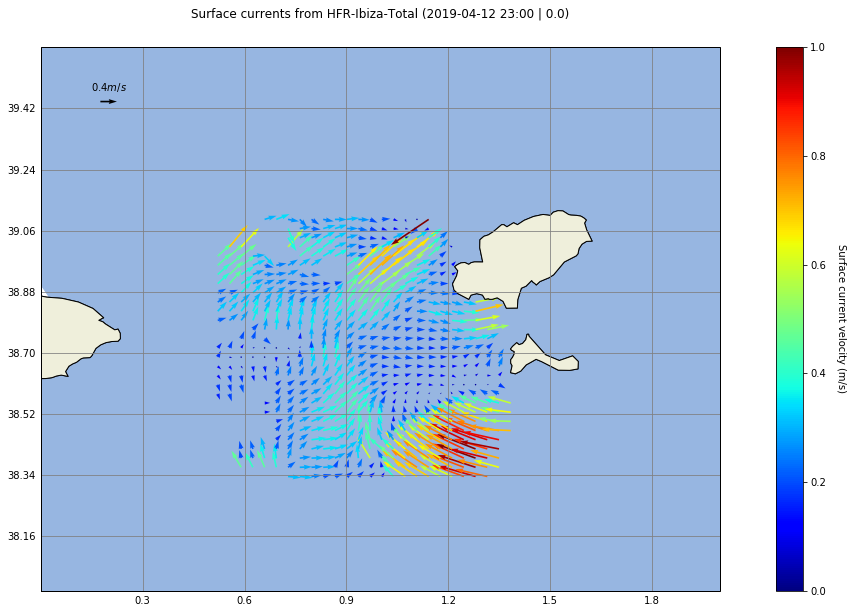

In [55]:
plt.figure(figsize=(20, 10))

#map initialization (projection, costallines, gridlines, bounds...)
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True,color='grey')
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent([0,2,39.6,38])

#map features (land & ocean)
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(land, zorder=1,edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, zorder=0)

#quiver plot (set vectors, colormaps and colorbars)
uvnorm = (U[time,depth,:,:]*U[time,depth,:,:] + V[time,depth,:,:]*V[time,depth,:,:])**0.5
norm = colors.Normalize(vmin=0, vmax=1)
Q=ax.quiver(lons, lats, U[time,depth,:,:],V[time,depth,:,:],uvnorm,transform=cartopy.crs.PlateCarree(), cmap='jet', norm=norm)
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
sm = plt.cm.ScalarMappable(cmap='jet',norm=norm)
sm._A = []
plt.colorbar(sm,ax=ax).ax.set_ylabel('Surface current velocity (m/s)', rotation=270, labelpad=20)

#plot title
times = cf_units.num2date(ds['TIME'], ds['TIME'].units, cf_units.CALENDAR_JULIAN)
plt.title('Surface currents from '+ds.platform_code+' ('+times[time].strftime("%Y-%m-%d %H:%M")+' | '+str(depths[depth])+')', pad=30)
plt.show()

<h1>time serie of surface currents at a point</h1>

For validation purposes it is very comon to extract the time evolution of the currents reported by radar sites at acertain point (this time serie is crossvalidated later against models, satellites and other insitu observing platforms monitoring such very same point).<br><br>
Let's choose a time range, location and depth to get a timeserie:

In [14]:
lat,lon = [38.52,0.9] #set any other location
depth = 0 #set anyother depth
ini = ds.time_coverage_start #choose any other. First value of the time coordinate is set as defaul.
end = ds.time_coverage_end #choose any other. Last value of the time coordinate is set as default.

Let's find the closest coordinates indexes to the above values:

In [15]:
datetime_ini = datetime.datetime.strptime(ini, "%Y-%m-%dT%H:%M:%SZ")
datetime_ini = cf_units.date2num(datetime_ini, ds['TIME'].units, cf_units.CALENDAR_JULIAN)
datetime_end = datetime.datetime.strptime(end ,"%Y-%m-%dT%H:%M:%SZ")
datetime_end = cf_units.date2num(datetime_end, ds['TIME'].units, cf_units.CALENDAR_JULIAN)

In [16]:
closer_lat_idx = (np.abs(lat - lats[:])).argmin()
closer_lon_idx = (np.abs(lon - lons[:])).argmin()
closer_time_ini_index = (np.abs(datetime_ini - ds['TIME'])).argmin()
closer_time_end_index = (np.abs(datetime_end - ds['TIME'])).argmin()

In [17]:
print('original lat | closer lat found: '+str(lat)+' | '+str(lats[closer_lat_idx]))
print('original lon | closer lon found: '+str(lon)+' | '+str(lons[closer_lon_idx]))
print('original ini | closer ini found: '+str(ini)+' | '+str(times[closer_time_ini_index]))
print('original end | closer end found: '+str(end)+' | '+str(times[closer_time_end_index]))

original lat | closer lat found: 38.52 | 38.52569
original lon | closer lon found: 0.9 | 0.90050983
original ini | closer ini found: 2019-04-11T23:30:00Z | 2019-04-12 00:00:00
original end | closer end found: 2019-04-12T23:30:00Z | 2019-04-12 23:00:56


Le's extract the serie:

In [18]:
U_timeserie = U[closer_time_ini_index:closer_time_end_index,depth,closer_lat_idx, closer_lon_idx]
V_timeserie = V[closer_time_ini_index:closer_time_end_index,depth,closer_lat_idx, closer_lon_idx]
time_timeserie = [item.strftime("%H:%M") for item in times[closer_time_ini_index:closer_time_end_index]]

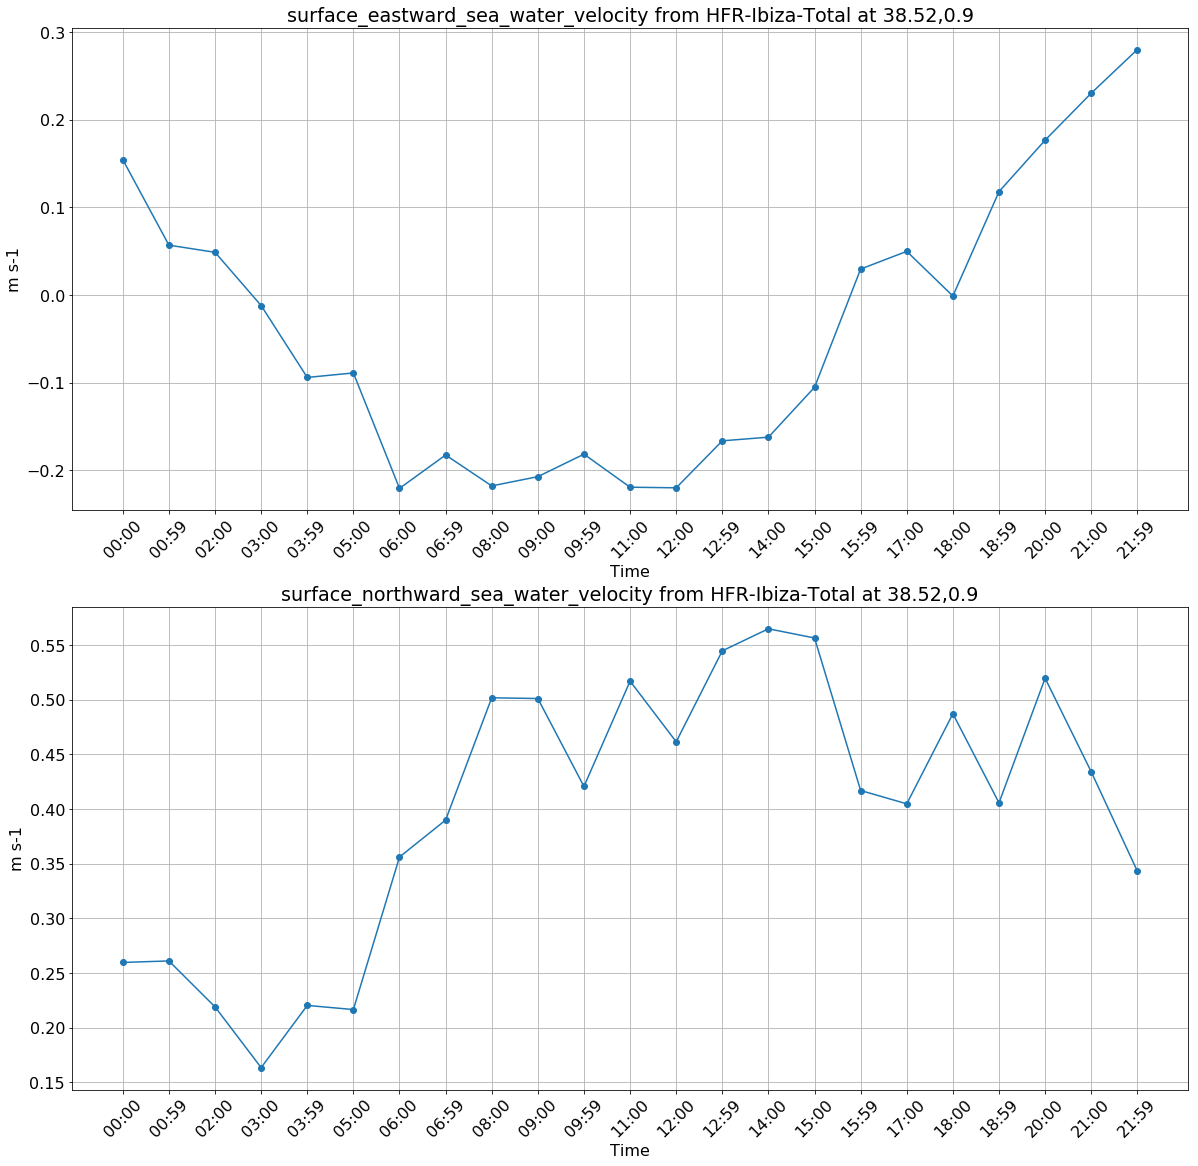

In [19]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(2, 1, 1)
plt.plot(time_timeserie, U_timeserie, '-o')
plt.xlabel('Time')
plt.ylabel(U.units)
plt.title(U.standard_name +' from '+ ds.platform_code+' at '+str(lat)+','+str(lon))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_timeserie, V_timeserie, '-o')
plt.xlabel('Time')
plt.ylabel(V.units)
plt.title(V.standard_name +' from '+ ds.platform_code+' at '+str(lat)+','+str(lon))
plt.xticks(rotation=45)
plt.grid(True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.6, wspace=None, hspace=None)
plt.show()

<h1>HF-radar performance: 80/80 metrics </hr>

In [20]:
d = parse_duration(ds.time_coverage_resolution)
hours = d.seconds/3600
data_frequency = 24/hours

In [21]:
result = {}
for key in ['EWCT', 'NSCT']:
    result[key], array = {}, []
    xy = np.meshgrid(lats,lons)
    for j in range(0, len(xy[1])):
        for i in range(0, len(xy[0])):
            values =  ds[key][:,0,j,i]
            noNans_values = [val for val in values if np.isnan(val) == False]
            percentage = (100*len(noNans_values))/len(values)
            array.append(percentage)
    for i in range(0,100,1):
        subset = [val for val in array if val>=i]
        result[key][i] = (len(subset)*100)/len(array)
    result[key] = collections.OrderedDict(sorted(result[key].items()))

Text(81, 81, '80/80')

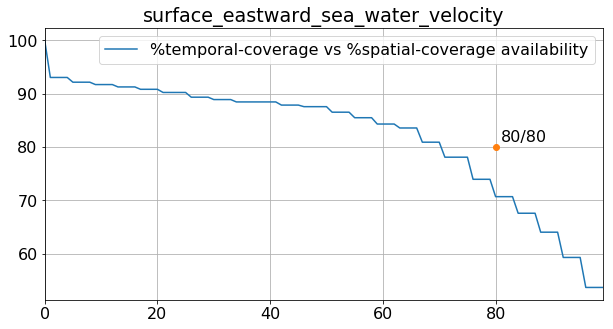

In [26]:
dataframe = pd.DataFrame(data=result['EWCT'].values(), index=result['EWCT'].keys(), columns = ['%temporal-coverage vs %spatial-coverage availability'])
plt_bare = dataframe.plot(grid=True, figsize=(10,5), title=U.standard_name)
plt_bare.plot(80,80,'-o')
plt_bare.text(81,81, '80/80')

Text(81, 81, '80/80')

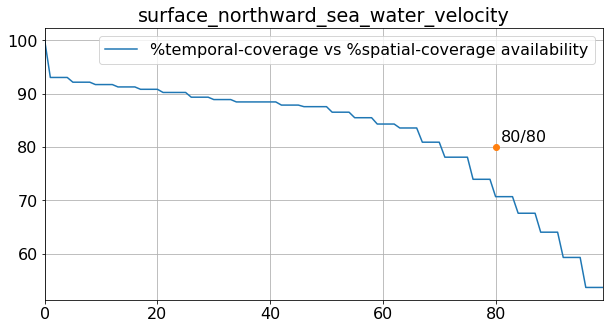

In [27]:
dataframe = pd.DataFrame(data=result['NSCT'].values(), index=result['NSCT'].keys(), columns = ['%temporal-coverage vs %spatial-coverage availability'])
plt_bare = dataframe.plot(grid=True, figsize=(10,5), title=V.standard_name)
plt_bare.plot(80,80,'-o')
plt_bare.text(81,81, '80/80')